In [1]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from torchvision import models
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.nn.functional as F
#from einops import rearrange, repeat
#from einops.layers.torch import Rearrange
import math
import numpy as np
import time
from torch import einsum
import cv2
import scipy.misc
#import utils
import tqdm
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
class biGRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, laten_size):
        super(biGRU, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size,hidden_size=hidden_size,
                         num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, 1)
        self.fc_latent = nn.Linear(hidden_size*2, laten_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        #h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h_0)
        content_out = self.fc_latent(out[:, 10, :])
        dis_out = self.fc(out[:, 10, :]) # 과거 10개, 현재 5개
        #out = self.fc(out[:, -1, :]) # 과거 15개개

        return content_out, dis_out

In [3]:
num_classes = 2
input_size = 7
hidden_size = 128
num_layers = 2
seq_length = 15
latent_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = biGRU(num_classes, input_size, hidden_size, num_layers, seq_length, latent_size).to(device)

In [5]:
model.load_state_dict(torch.load('content_encoder.pth', map_location=device))

<All keys matched successfully>

In [6]:
real_df = pd.read_csv("real_squat_data.csv")

real_df.head()

,UWB,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,updown
0,0.723169,0.847622,-0.831826,1.067376,-1.483318,0.816265,0.329999,0
1,0.723169,-0.305767,0.605308,0.871359,-0.961083,0.751001,0.850115,0
2,0.795571,-0.305767,0.605308,0.871359,-0.961083,0.751001,0.850115,0
3,0.867973,2.503732,-0.901515,0.520150,-0.353930,0.990736,0.576363,0
4,0.766610,2.503732,-0.901515,0.520150,-0.353930,0.990736,0.576363,0


In [7]:
tmp = real_df['updown'].shift(1).fillna(0)
squat_ends = real_df[(tmp == 1) & (real_df['updown'] == 0)].index
print(f"Total squat ends: {len(squat_ends)}")
print(squat_ends)

squat_sets = []

start_index = 0
for end_index in squat_ends:
    one_set = real_df.iloc[start_index:end_index+1]

    squat_sets.append(one_set)
    print(f"len of oneset:{len(one_set)}")
    #squat_sets.append(one_set)
    print(f"start_index: {start_index}, end_index: {end_index}")
    start_index = end_index + 1


print(f"Total sets: {len(squat_sets)}")

Total squat ends: 67
Index([  95,  184,  272,  369,  450,  528,  602,  671,  791,  883,  982, 1077,
       1172, 1263, 1351, 1444, 1544, 1636, 1719, 1805, 1896, 1983, 2071, 2158,
       2251, 2355, 2431, 2511, 2599, 2691, 2779, 2868, 2955, 3040, 3132, 3214,
       3303, 3390, 3479, 3558, 3638, 3712, 3787, 3867, 3953, 4032, 4115, 4201,
       4296, 4380, 4450, 4517, 4603, 4684, 4763, 4844, 4926, 5005, 5086, 5166,
       5257, 5322, 5396, 5480, 5557, 5650, 5741],
      dtype='int64')
len of oneset:96
start_index: 0, end_index: 95
len of oneset:89
start_index: 96, end_index: 184
len of oneset:88
start_index: 185, end_index: 272
len of oneset:97
start_index: 273, end_index: 369
len of oneset:81
start_index: 370, end_index: 450
len of oneset:78
start_index: 451, end_index: 528
len of oneset:74
start_index: 529, end_index: 602
len of oneset:69
start_index: 603, end_index: 671
len of oneset:120
start_index: 672, end_index: 791
len of oneset:92
start_index: 792, end_index: 883
len of oneset:99

In [8]:
X = []
y = []

for one_set in squat_sets:
    for i in range(9, len(one_set)-15, 5):
        X.append(one_set.iloc[i-9:i+6, :7].values)
        y.append(one_set.iloc[i]['updown'])

X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(853, 15, 7) (853,)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Training set size: 682
Validation set size: 85
Testing set size: 86
(682, 15, 7)
(85, 15, 7)
(86, 15, 7)


In [10]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
num_classes = 2
input_size = 7
hidden_size = 128
num_layers = 2
seq_length = 15

criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 50

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [12]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        _, outputs = model(inputs)
        preds = (outputs > 0.5).float()
        labels = labels.unsqueeze(1).float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #_, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [13]:
def evaluate(model, data_loader, criterion, device, phase="validation"):
    global best_val_acc
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"Evaluating {phase}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            _, outputs = model(inputs)
            preds = (outputs > 0.5).float()
            labels = labels.unsqueeze(1).float()
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            #_, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    accuracy = 100 * correct / total
    print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Accuracy: {accuracy:.2f}%")
    if phase == "validation":
        val_losses.append(epoch_loss)
        val_accuracies.append(accuracy)
        if accuracy > best_val_acc:
            best_val_acc = accuracy
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")
    if phase == "test":
        test_accuracy = accuracy
        print(f"Test Accuracy: {test_accuracy:.2f}%")

        f1_score_result = f1_score(all_labels, all_predictions)
        recall_score_result = recall_score(all_labels, all_predictions)
        precision_score_result = precision_score(all_labels, all_predictions)

        return f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions

In [14]:
best_val_acc = 0.0
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="validation")

Epoch [1/50]


Train Loss: 0.1147, Train Accuracy: 54.84%


Validation Loss: 0.1054, Validation Accuracy: 54.12%
Best model saved!
Epoch [2/50]


Train Loss: 0.0795, Train Accuracy: 61.73%


Validation Loss: 0.0759, Validation Accuracy: 60.00%
Best model saved!
Epoch [3/50]


Train Loss: 0.0536, Train Accuracy: 68.48%


Validation Loss: 0.0557, Validation Accuracy: 63.53%
Best model saved!
Epoch [4/50]


Train Loss: 0.0391, Train Accuracy: 73.31%


Validation Loss: 0.0402, Validation Accuracy: 65.88%
Best model saved!
Epoch [5/50]


Train Loss: 0.0291, Train Accuracy: 76.10%


Validation Loss: 0.0298, Validation Accuracy: 71.76%
Best model saved!
Epoch [6/50]


Train Loss: 0.0239, Train Accuracy: 79.18%


Validation Loss: 0.0261, Validation Accuracy: 75.29%
Best model saved!
Epoch [7/50]


Train Loss: 0.0198, Train Accuracy: 80.50%


Validation Loss: 0.0234, Validation Accuracy: 76.47%
Best model saved!
Epoch [8/50]


Train Loss: 0.0167, Train Accuracy: 82.84%


Validation Loss: 0.0213, Validation Accuracy: 81.18%
Best model saved!
Epoch [9/50]


Train Loss: 0.0145, Train Accuracy: 85.04%


Validation Loss: 0.0202, Validation Accuracy: 81.18%
Epoch [10/50]


Train Loss: 0.0126, Train Accuracy: 85.92%


Validation Loss: 0.0191, Validation Accuracy: 84.71%
Best model saved!
Epoch [11/50]


Train Loss: 0.0115, Train Accuracy: 87.10%


Validation Loss: 0.0182, Validation Accuracy: 84.71%
Epoch [12/50]


Train Loss: 0.0103, Train Accuracy: 88.27%


Validation Loss: 0.0175, Validation Accuracy: 85.88%
Best model saved!
Epoch [13/50]


Train Loss: 0.0096, Train Accuracy: 89.00%


Validation Loss: 0.0173, Validation Accuracy: 84.71%
Epoch [14/50]


Train Loss: 0.0091, Train Accuracy: 89.15%


Validation Loss: 0.0169, Validation Accuracy: 88.24%
Best model saved!
Epoch [15/50]


Train Loss: 0.0082, Train Accuracy: 89.88%


Validation Loss: 0.0165, Validation Accuracy: 88.24%
Epoch [16/50]


Train Loss: 0.0086, Train Accuracy: 90.76%


Validation Loss: 0.0160, Validation Accuracy: 89.41%
Best model saved!
Epoch [17/50]


Train Loss: 0.0074, Train Accuracy: 91.20%


Validation Loss: 0.0158, Validation Accuracy: 87.06%
Epoch [18/50]


Train Loss: 0.0069, Train Accuracy: 91.79%


Validation Loss: 0.0154, Validation Accuracy: 87.06%
Epoch [19/50]


Train Loss: 0.0069, Train Accuracy: 92.67%


Validation Loss: 0.0152, Validation Accuracy: 88.24%
Epoch [20/50]


Train Loss: 0.0063, Train Accuracy: 92.82%


Validation Loss: 0.0149, Validation Accuracy: 89.41%
Epoch [21/50]


Train Loss: 0.0061, Train Accuracy: 92.96%


Validation Loss: 0.0149, Validation Accuracy: 89.41%
Epoch [22/50]


Train Loss: 0.0060, Train Accuracy: 92.96%


Validation Loss: 0.0148, Validation Accuracy: 89.41%
Epoch [23/50]


Train Loss: 0.0065, Train Accuracy: 93.26%


Validation Loss: 0.0149, Validation Accuracy: 89.41%
Epoch [24/50]


Train Loss: 0.0054, Train Accuracy: 93.40%


Validation Loss: 0.0145, Validation Accuracy: 89.41%
Epoch [25/50]


Train Loss: 0.0052, Train Accuracy: 94.28%


Validation Loss: 0.0143, Validation Accuracy: 89.41%
Epoch [26/50]


Train Loss: 0.0048, Train Accuracy: 94.28%


Validation Loss: 0.0142, Validation Accuracy: 89.41%
Epoch [27/50]


Train Loss: 0.0046, Train Accuracy: 94.57%


Validation Loss: 0.0144, Validation Accuracy: 89.41%
Epoch [28/50]


Train Loss: 0.0045, Train Accuracy: 95.01%


Validation Loss: 0.0144, Validation Accuracy: 89.41%
Epoch [29/50]


Train Loss: 0.0044, Train Accuracy: 94.87%


Validation Loss: 0.0144, Validation Accuracy: 89.41%
Epoch [30/50]


Train Loss: 0.0039, Train Accuracy: 95.16%


Validation Loss: 0.0142, Validation Accuracy: 89.41%
Epoch [31/50]


Train Loss: 0.0037, Train Accuracy: 95.16%


Validation Loss: 0.0142, Validation Accuracy: 89.41%
Epoch [32/50]


Train Loss: 0.0037, Train Accuracy: 95.45%


Validation Loss: 0.0141, Validation Accuracy: 89.41%
Epoch [33/50]


Train Loss: 0.0037, Train Accuracy: 95.60%


Validation Loss: 0.0143, Validation Accuracy: 89.41%
Epoch [34/50]


Train Loss: 0.0034, Train Accuracy: 95.89%


Validation Loss: 0.0142, Validation Accuracy: 89.41%
Epoch [35/50]


Train Loss: 0.0035, Train Accuracy: 96.04%


Validation Loss: 0.0143, Validation Accuracy: 89.41%
Epoch [36/50]


Train Loss: 0.0034, Train Accuracy: 96.19%


Validation Loss: 0.0141, Validation Accuracy: 89.41%
Epoch [37/50]


Train Loss: 0.0032, Train Accuracy: 96.04%


Validation Loss: 0.0141, Validation Accuracy: 89.41%
Epoch [38/50]


Train Loss: 0.0031, Train Accuracy: 96.19%


Validation Loss: 0.0139, Validation Accuracy: 89.41%
Epoch [39/50]


Train Loss: 0.0031, Train Accuracy: 96.63%


Validation Loss: 0.0139, Validation Accuracy: 89.41%
Epoch [40/50]


Train Loss: 0.0029, Train Accuracy: 96.77%


Validation Loss: 0.0140, Validation Accuracy: 89.41%
Epoch [41/50]


Train Loss: 0.0029, Train Accuracy: 96.63%


Validation Loss: 0.0140, Validation Accuracy: 89.41%
Epoch [42/50]


Train Loss: 0.0028, Train Accuracy: 96.77%


Validation Loss: 0.0138, Validation Accuracy: 89.41%
Epoch [43/50]


Train Loss: 0.0028, Train Accuracy: 97.07%


Validation Loss: 0.0138, Validation Accuracy: 89.41%
Epoch [44/50]


Train Loss: 0.0027, Train Accuracy: 97.07%


Validation Loss: 0.0137, Validation Accuracy: 89.41%
Epoch [45/50]


Train Loss: 0.0027, Train Accuracy: 97.21%


Validation Loss: 0.0137, Validation Accuracy: 90.59%
Best model saved!
Epoch [46/50]


Train Loss: 0.0026, Train Accuracy: 97.21%


Validation Loss: 0.0138, Validation Accuracy: 89.41%
Epoch [47/50]


Train Loss: 0.0026, Train Accuracy: 97.51%


Validation Loss: 0.0136, Validation Accuracy: 90.59%
Epoch [48/50]


Train Loss: 0.0027, Train Accuracy: 97.65%


Validation Loss: 0.0135, Validation Accuracy: 90.59%
Epoch [49/50]


Train Loss: 0.0024, Train Accuracy: 97.51%


Validation Loss: 0.0135, Validation Accuracy: 90.59%
Epoch [50/50]


Train Loss: 0.0024, Train Accuracy: 97.51%


Validation Loss: 0.0135, Validation Accuracy: 90.59%


In [15]:
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)
f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions = evaluate(model, test_loader, criterion, device, phase="test")

Test Loss: 0.0058, Test Accuracy: 90.70%
Test Accuracy: 90.70%


In [16]:
print(f"F1 Score: {f1_score_result:.4f}")
print(f"Recall Score: {recall_score_result:.4f}")
print(f"Precision Score: {precision_score_result:.4f}")

F1 Score: 0.9167
Recall Score: 0.8980
Precision Score: 0.9362


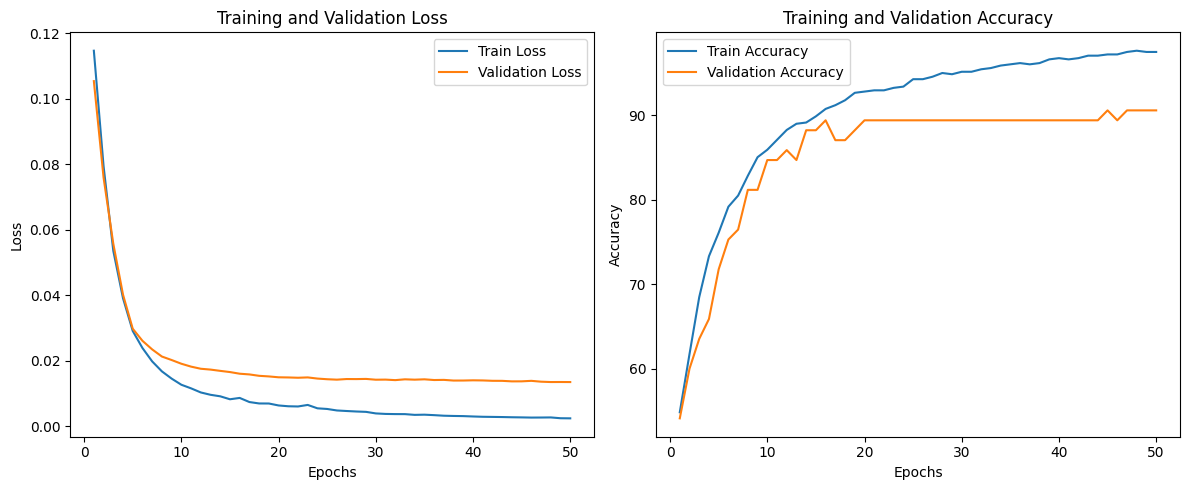

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss}
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()